## Data Regularization using Data Augmentation

### Import packages

In [1]:
from fasttext import util as fasttext_utils
from itertools import combinations
import networkx as nx
import pandas as pd
import numpy as np
import fasttext
import os
import io

In [2]:
RAW_DATA_FOLDER = "raw_data"
STAGING_DATA_FOLDER = "staging_data"
CLEAN_DATA_FOLDER = "clean_data"

### Load the question pairs to a dataframe

In [3]:
# q_pairs = pd.read_csv(os.path.join(STAGING_DATA_FOLDER, "question_pairs.csv"), index_col="id")
train_df = pd.read_csv(os.path.join(STAGING_DATA_FOLDER, "train.csv")) # updated
validation_df = pd.read_csv(os.path.join(STAGING_DATA_FOLDER, "validation.csv")) # updated

### Generate edges from the question pairs

In [4]:
# qids = (
#     q_pairs[["qid1", "qid2", "is_duplicate"]]
#     .sort_values(["qid1", "qid2"])
#     .to_numpy()
#     .tolist()
# )
qids = (
    train_df[["qid1", "qid2", "is_duplicate"]]
    .sort_values(["qid1", "qid2"])
    .to_numpy()
    .tolist()
) # qids is a list of tuples and each tuple corresponds to a row in the question pairs dataframe and is of the format (qid1, qid2, is_duplicate)
edges = []
for qid1, qid2, is_duplicate in qids:
    if is_duplicate:
        edges.append([qid1, qid2]) # edges is a list of tuple where each tuple is qid1 and qid2. we are only including tuples whose id_duplicate = 1

### Generate Graph from the edges

In [5]:
G = nx.Graph() # nx is a graph creation utility. Here we are declaring an empty undirected graph.
G.add_edges_from(edges) # Add all the edges from above to populate our graph.
edges = list(G.edges)
nodes = list(G.nodes)
components = list(nx.connected_components(G))

In [6]:
components[:5]

[{11, 12},
 {25, 26, 114035},
 {27, 28, 50277},
 {31,
  32,
  1100,
  1101,
  2066,
  2067,
  6079,
  6080,
  6937,
  6938,
  7751,
  7752,
  8577,
  8578,
  11434,
  11435,
  12544,
  16474,
  17171,
  24203,
  24204,
  24960,
  32509,
  32957,
  36835,
  36836,
  37617,
  38502,
  44686,
  46127,
  51528,
  53535,
  64848,
  77287,
  81385,
  83195,
  88834,
  93145,
  93146,
  100431,
  106091,
  120229,
  132922,
  140488,
  140581,
  167907,
  218253,
  221900,
  249733,
  258354,
  333813,
  528360},
 {33, 34}]

### Drop trivial components (number of nodes in component is 2)

In [7]:
components = [x for x in components if len(x) != 2]

In [8]:
components[:5]

[{25, 26, 114035},
 {27, 28, 50277},
 {31,
  32,
  1100,
  1101,
  2066,
  2067,
  6079,
  6080,
  6937,
  6938,
  7751,
  7752,
  8577,
  8578,
  11434,
  11435,
  12544,
  16474,
  17171,
  24203,
  24204,
  24960,
  32509,
  32957,
  36835,
  36836,
  37617,
  38502,
  44686,
  46127,
  51528,
  53535,
  64848,
  77287,
  81385,
  83195,
  88834,
  93145,
  93146,
  100431,
  106091,
  120229,
  132922,
  140488,
  140581,
  167907,
  218253,
  221900,
  249733,
  258354,
  333813,
  528360},
 {37,
  38,
  1357,
  1358,
  2374,
  2375,
  4407,
  4408,
  4950,
  4951,
  5041,
  5042,
  6551,
  6552,
  10957,
  10958,
  12638,
  12639,
  14772,
  17258,
  17259,
  17506,
  17507,
  17811,
  17812,
  17854,
  18276,
  18277,
  18296,
  18629,
  19621,
  19789,
  20096,
  20128,
  21374,
  21712,
  21713,
  22873,
  26053,
  26054,
  26184,
  26185,
  27517,
  28236,
  28639,
  29331,
  31868,
  32032,
  32200,
  33412,
  35498,
  37698,
  38315,
  42108,
  43745,
  44331,
  47020,
  47

### Generate all potential edges

for each component, identify all potential edges, and only choose edges which don't have a direct path in the component

In [9]:
def can_add_edge(G, u, v):
    if G.has_edge(u, v) or G.has_edge(v, u):
        # Edge already exists
        return False
    if nx.has_path(G, u, v) or nx.has_path(G, v, u):
        # Adding this edge doesn't connect different components
        return True
    return False

In [10]:
new_edges = []
for component in components:
    potential_edges = combinations(sorted(component), 2)
    for u, v in potential_edges:
        if can_add_edge(G, u, v):
            new_edges.append((u, v))

### These are the number of new edges (duplicate question pairs)

In [11]:
len(new_edges)

91227

### Add the new edges to question pairs

In [12]:
df = pd.DataFrame([{"qid1": u, "qid2": v, "is_duplicate": 1} for u, v in new_edges])
# q_pairs = pd.concat([q_pairs, df], axis=0)
q_pairs = pd.concat([train_df[["qid1", "qid2", "is_duplicate"]], df], axis=0) # updated
q_pairs = q_pairs.sort_values(["qid1", "qid2"]).reset_index().drop(columns="index")

In [13]:
q_pairs.head()

,qid1,qid2,is_duplicate
0,1,2,0
1,3,4,0
2,3,488853,0
3,4,32881,0
4,7,8,0


In [14]:
# q_pairs.to_csv(os.path.join(CLEAN_DATA_FOLDER, "question_pairs.csv"), index_label="id")
q_pairs.to_csv(os.path.join(STAGING_DATA_FOLDER, "train.csv"), index_label="id") # updated

In [15]:
# (len(q_pairs)-(q_pairs["is_duplicate"].sum()))/(len(q_pairs))
total_pairs = len(q_pairs) + len(validation_df)
positive_pairs = q_pairs["is_duplicate"].sum() + validation_df["is_duplicate"].sum()
(total_pairs - positive_pairs) / total_pairs # the ratio of 0:1

0.5044656497778716

***The balance between 0 and 1 in the (train+validation) set is now 50-50.***

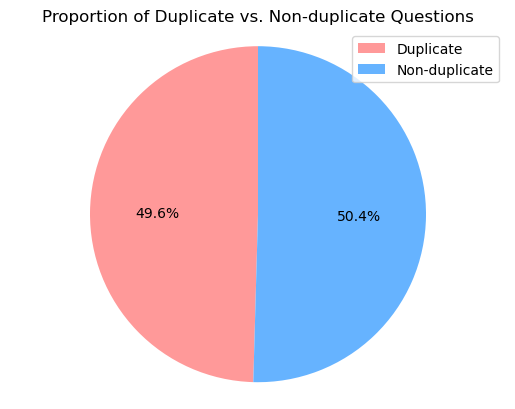

In [16]:
import matplotlib.pyplot as plt

# Calculate percentages
duplicate_percent = (positive_pairs / total_pairs) * 100
non_duplicate_percent = ((total_pairs - positive_pairs) / total_pairs) * 100

# Plot the pie chart
labels = ['Duplicate', 'Non-duplicate']
sizes = [duplicate_percent, non_duplicate_percent]
colors = ['#ff9999','#66b3ff']
plt.pie(sizes, colors=colors, autopct='%1.1f%%', startangle=90)
plt.title('Proportion of Duplicate vs. Non-duplicate Questions')
plt.legend(labels, loc='upper right')
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.show()

## Data Transformation using Fasttext and Glove Embeddings

#### Data Transformation Using FastText

#### pip install fasttext - to install the helper code for fasttext

In [17]:
# 300 is the default embedding dimensions for fasttext.
# each word in the vocab will be assigned a 300-dimensional vector
embed_dimension = 300

In [18]:
# load the fasttext model which contains all the words it has already learned and the corresponding embeddings
ft_model = fasttext.load_model(os.path.join(RAW_DATA_FOLDER, "fasttext.cc.en.300d.bin"))

In [19]:
# Reading vocab.tsv which we created earlier
# vocab = pd.read_csv(
#     os.path.join(STAGING_DATA_FOLDER, "vocab.tsv"),
#     sep="\t",
#     index_col="id",
#     keep_default_na=False, # n/a can be read/interpreted as null in pandas. So we are telling Pandas dont do it please
# )

vocab = pd.read_csv(
    os.path.join(CLEAN_DATA_FOLDER, "vocab.tsv"), # updated
    sep="\t",
    index_col="id",
    keep_default_na=False, # n/a can be read/interpreted as null in pandas. So we are telling Pandas dont do it please
)
vocab = vocab["token"].tolist() # stroing all the tokens from vocab.tsv

# for token in ft_model.get_words(): # get all the tokens from fasttext embeddings and store it in our vocab variable
#     vocab.append(token)
# vocab = sorted(set(vocab)) # set function removes the duplicate/ common words from both and sorted will sort them.

# we are doing this because fasttext words contains words which are not in our dataset. We are not sure what words are 
#present in real world or test data. So, better to store everything.

In [20]:
vocab[:30]

['!',
 '#',
 '$',
 '%',
 '&',
 "'",
 "''",
 "'+",
 "'-",
 "'-=",
 "'00s",
 "'08",
 "'10",
 "'10-4",
 "'100",
 "'10n'.how",
 "'10s",
 "'11",
 "'14",
 "'15",
 "'16",
 "'17",
 "'1729",
 "'1984",
 "'2048",
 "'2k",
 "'363^1/2",
 "'40s",
 "'50",
 "'55"]

In [21]:
vocab[-30:]

['북쪽앟관자키',
 '분위기',
 '불타오르네',
 '슬마',
 '심하잖아',
 '이정현',
 '친구해도',
 '쾌지나칭칭나네',
 '하지만',
 '한글',
 '\uf04c',
 '\uf09ewhat',
 '\uf0b7',
 'ﬁnd',
 '\ufeff',
 '\ufeffcatching',
 '\ufefflord',
 '\ufeffthe',
 '！？',
 '（白左）become',
 '，how',
 '，in',
 '，song',
 '，what',
 '，|',
 '？',
 '？and',
 '￦¥§¤㊙㊗',
 '￼how',
 '￼what']

In [22]:
# embeddings = []
embeddings = [[0.0] * embed_dimension] # updated, include the default embedding for <pad>
for token in vocab:
    embeddings.append(ft_model.get_word_vector(token))

# This generates word embeddings/vectors for all the words/tokens in vocab variable using fasttext model (ft_model)

In [23]:
# # Save two lists, vocab and embeddings, into a tsv file
# filepath = os.path.join(CLEAN_DATA_FOLDER, f"dataset.fasttext.{embed_dimension}d.tsv")
# with open(filepath, "w") as fp:
#     fp.write("id\ttoken\tembedding\n")
#     for idx, token, embedding in zip(list(range(len(embeddings))), vocab, embeddings):
#         fp.write(f"{idx}\t{token}\t{' '.join([str(x) for x in embedding])}\n")

embeddings = np.asarray(embeddings) # updated, convert the embedding list to numpy ndarray
np.save(os.path.join(CLEAN_DATA_FOLDER, f"fasttext.{embed_dimension}d.embeddings.npy"), embeddings) # updated, save numpy embeddings

#### Data Reduction using PCA for FastText Embeddings

In [24]:
# each word in the vocab will be assigned a 100-dimensional vector
embed_dimension = 100

In [25]:
# this does PCA internally
if embed_dimension < 300:
    fasttext_utils.reduce_model(ft_model, embed_dimension)

In [26]:
# Reading vocab.tsv which we created earlier
# vocab = pd.read_csv(
#     os.path.join(STAGING_DATA_FOLDER, "vocab.tsv"),
#     sep="\t",
#     index_col="id",
#     keep_default_na=False, # n/a can be read/interpreted as null in pandas. So we are telling Pandas dont do it please
# )

vocab = pd.read_csv(
    os.path.join(CLEAN_DATA_FOLDER, "vocab.tsv"), # updated
    sep="\t",
    index_col="id",
    keep_default_na=False, # n/a can be read/interpreted as null in pandas. So we are telling Pandas dont do it please
)
vocab = vocab["token"].tolist() # stroing all the tokens from vocab.tsv

# for token in ft_model.get_words(): # get all the tokens from fasttext embeddings and store it in our vocab variable
#     vocab.append(token)
# vocab = sorted(set(vocab)) # set function removes the duplicate/ common words from both and sorted will sort them.

# we are doing this because fasttext words contains words which are not in our dataset. We are not sure what words are 
#present in real world or test data. So, better to store everything.

In [27]:
vocab[:30]

['!',
 '#',
 '$',
 '%',
 '&',
 "'",
 "''",
 "'+",
 "'-",
 "'-=",
 "'00s",
 "'08",
 "'10",
 "'10-4",
 "'100",
 "'10n'.how",
 "'10s",
 "'11",
 "'14",
 "'15",
 "'16",
 "'17",
 "'1729",
 "'1984",
 "'2048",
 "'2k",
 "'363^1/2",
 "'40s",
 "'50",
 "'55"]

In [28]:
# embeddings = [] 
embeddings = [[0.0] * embed_dimension] # updated, include the default embedding for <pad>
for token in vocab:
    embeddings.append(ft_model.get_word_vector(token))

# This generates word embeddings/vectors for all the words/tokens in vocab variable using fasttext model (ft_model)

In [29]:
# # Save two lists, vocab and embeddings, into a tsv file
# filepath = os.path.join(CLEAN_DATA_FOLDER, f"dataset.fasttext.{embed_dimension}d.tsv")
# with open(filepath, "w") as fp:
#     fp.write("id\ttoken\tembedding\n")
#     for idx, token, embedding in zip(list(range(len(embeddings))), vocab, embeddings):
#         fp.write(f"{idx}\t{token}\t{' '.join([str(x) for x in embedding])}\n")

embeddings = np.asarray(embeddings) # updated, convert the embedding list to numpy ndarray
np.save(os.path.join(CLEAN_DATA_FOLDER, f"fasttext.{embed_dimension}d.embeddings.npy"), embeddings) # updated, save numpy embeddings

difference between fasttext and Glove

- fasttext can generate a word embeddings which is not present in it initially. ( thats why we need to install fasttext).

- Glove cannot do that. So we might have to use tricks like,
1. if we cannot find an embedding for a word we need to split that word into individual tokens that are present in Glove embeddings
2. the embedding for this word will be the mean of embeddings created above.
3. If we can still not find it the embeddings will be zeros for that word.

#### Data Transformation using GloVe Embeddings

In [30]:
embed_dimension = 300

In [31]:
# Loading Glove embedding
glove = {}
fin = io.open(
    os.path.join(RAW_DATA_FOLDER, f"glove.6B.{embed_dimension}d.txt"),
    "r",
    encoding="utf-8",
    newline="\n",
    errors="ignore",
)
for line in fin:
    tokens = line.rstrip().split(" ")
    glove[tokens[0]] = list(map(float, tokens[1:]))

In [32]:
# vocab = pd.read_csv(
#     os.path.join(STAGING_DATA_FOLDER, "vocab.tsv"),
#     sep="\t",
#     index_col="id",
#     keep_default_na=False,
# )
# vocab = [x.lower() for x in vocab["token"].tolist()]

vocab = pd.read_csv(
    os.path.join(CLEAN_DATA_FOLDER, "vocab.tsv"), # updated
    sep="\t",
    index_col="id",
    keep_default_na=False,
)
vocab = vocab["token"].tolist() # updated

# for token in glove.keys():
#     vocab.append(token)
# vocab = sorted(set(vocab))

In [33]:
# storing words/ tokens in oov which are not present in the glove embeddings
oov = []
for token in vocab:
    if token not in glove:
        oov.append(token)
oov = sorted(oov, key=len)

given a dictionary of word and its embeddings the below function will try to generate an embedding for a word that is not in the given dictionary

It does so by first identifying substrings of the word which are present in the dictionary.

once the sub strings have been identified the embedding for this new word will be the mean of the substrings.

example - tiktoken - the substrings will be tik and token.

tik will have a vector embedding of 100 or 300 dimension [ ]
token will have a vector embedding of 100 or 300 dimension [ ]
the mean of both the vectors is generated/calculated and that is the vector embedding for tiktoken

In [34]:
def find_words_from_dict(dictionary, input_string):
    n = len(input_string)
    dp = [False] * (n + 1)
    dp[0] = True
    parent = [-1] * (
        n + 1
    )  # To store the starting index of the word that ends at position i

    # Filling dp array
    for i in range(1, n + 1):
        for j in range(i):
            if dp[j] and input_string[j:i] in dictionary:
                dp[i] = True
                parent[i] = j
                break

    # If dp[n] is False, it's not possible to construct the string
    if not dp[-1]:
        return -1

    # Recovering the words from the input string
    result = [0] * embed_dimension
    current = n
    count = 0
    while current > 0:
        start = parent[current]
        word = input_string[start:current]
        result = [result[i] + dictionary[word][i] for i in range(embed_dimension)]
        count += 1
        current = start

    return [x / count for x in result]

In [35]:
#if the above function returns -1 then storing those words/ tokens in ooov
ooov = []
for oov_token in oov:
    embedding = find_words_from_dict(glove, oov_token)
    if embedding == -1:
        ooov.append(oov_token)
    # else: # if embeddings are returned (mean), storing then in glove dictionary
    #     glove[oov_token] = embedding
ooov = sorted(ooov, key=len)

In [36]:
# embeddings = []
embeddings = [[0.0] * embed_dimension] # updated, include the default embedding for <pad>
for token in vocab:
    if token in glove:
        embeddings.append(glove[token])
    elif token in ooov:
        embeddings.append([0.0] * embed_dimension) # for word still not having embedding
    else:
        embeddings.append(find_words_from_dict(glove, token))

In [37]:
# with open(os.path.join(CLEAN_DATA_FOLDER, f"dataset.glove.{embed_dimension}d.tsv"), "w") as fp:
#     fp.write("id\ttoken\tembedding\n")
#     for idx, token, embedding in zip(list(range(len(embeddings))), vocab, embeddings):
#         fp.write(f"{idx}\t{token}\t{' '.join([str(x) for x in embedding])}\n")

embeddings = np.asarray(embeddings) # updated, convert the embedding list to numpy ndarray
np.save(os.path.join(CLEAN_DATA_FOLDER, f"glove.{embed_dimension}d.embeddings.npy"), embeddings) # updated, save numpy embeddings

#### Data Reduction using PCA for GloVe Embeddings however 100d is already available

In [38]:
embed_dimension = 100

In [39]:
# Loading Glove embedding
glove = {}
fin = io.open(
    os.path.join(RAW_DATA_FOLDER, f"glove.6B.{embed_dimension}d.txt"),
    "r",
    encoding="utf-8",
    newline="\n",
    errors="ignore",
)
for line in fin:
    tokens = line.rstrip().split(" ")
    glove[tokens[0]] = list(map(float, tokens[1:]))

In [40]:
# vocab = pd.read_csv(
#     os.path.join(STAGING_DATA_FOLDER, "vocab.tsv"),
#     sep="\t",
#     index_col="id",
#     keep_default_na=False,
# )
# vocab = [x.lower() for x in vocab["token"].tolist()]

vocab = pd.read_csv(
    os.path.join(CLEAN_DATA_FOLDER, "vocab.tsv"), # updated
    sep="\t",
    index_col="id",
    keep_default_na=False,
)
vocab = vocab["token"].tolist() # updated

# for token in glove.keys():
#     vocab.append(token)
# vocab = sorted(set(vocab))

In [41]:
# storing words/ tokens in oov which are not present in the glove embeddings
oov = []
for token in vocab:
    if token not in glove:
        oov.append(token)
oov = sorted(oov, key=len)

In [42]:
def find_words_from_dict(dictionary, input_string):
    n = len(input_string)
    dp = [False] * (n + 1)
    dp[0] = True
    parent = [-1] * (
        n + 1
    )  # To store the starting index of the word that ends at position i

    # Filling dp array
    for i in range(1, n + 1):
        for j in range(i):
            if dp[j] and input_string[j:i] in dictionary:
                dp[i] = True
                parent[i] = j
                break

    # If dp[n] is False, it's not possible to construct the string
    if not dp[-1]:
        return -1

    # Recovering the words from the input string
    result = [0] * embed_dimension
    current = n
    count = 0
    while current > 0:
        start = parent[current]
        word = input_string[start:current]
        result = [result[i] + dictionary[word][i] for i in range(embed_dimension)]
        count += 1
        current = start

    return [x / count for x in result]

In [43]:
#if the above function returns -1 then storing those words/ tokens in ooov
ooov = []
for oov_token in oov:
    embedding = find_words_from_dict(glove, oov_token)
    if embedding == -1:
        ooov.append(oov_token)
    # else: # if embeddings are returned (mean), storing then in glove dictionary
    #     glove[oov_token] = embedding
ooov = sorted(ooov, key=len)

In [44]:
# embeddings = []
embeddings = [[0.0] * embed_dimension] # updated, include the default embedding for <pad>
for token in vocab:
    if token in glove:
        embeddings.append(glove[token])
    elif token in ooov:
        embeddings.append([0.0] * embed_dimension) # for word still not having embedding
    else:
        embeddings.append(find_words_from_dict(glove, token))

In [45]:
# with open(os.path.join(CLEAN_DATA_FOLDER, f"dataset.glove.{embed_dimension}d.tsv"), "w") as fp:
#     fp.write("id\ttoken\tembedding\n")
#     for idx, token, embedding in zip(list(range(len(embeddings))), vocab, embeddings):
#         fp.write(f"{idx}\t{token}\t{' '.join([str(x) for x in embedding])}\n")

embeddings = np.asarray(embeddings) # updated, convert the embedding list to numpy ndarray
np.save(os.path.join(CLEAN_DATA_FOLDER, f"glove.{embed_dimension}d.embeddings.npy"), embeddings) # updated, save numpy embeddings